In [1]:
%matplotlib inline
%pylab inline
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
from sklearn import svm
from sklearn import tree
from sklearn.metrics import confusion_matrix
from gensim.models import KeyedVectors
from sklearn.naive_bayes import GaussianNB

from inforet_package.preprocessing import *
from inforet_package.ensembler import *
from inforet_package.plotting import *
from inforet_package.vectorizer import *

Populating the interactive namespace from numpy and matplotlib


In [2]:
#loading data
df = pd.read_csv("../data/train.csv")

print("{} rows loaded...".format(df.shape[0]))
df = df.sample(frac=0.05)
print("{} rows sampled...".format(df.shape[0]))

1306122 rows loaded...
65306 rows sampled...


In [3]:
#Building terms features
questions = cleaning_questions(df)
tfidf_vocab, TfIdfMatrix, idf_dict = idf_dictionary_builder(questions)
cleaned_questions = clean_stopwords(questions, idf_dict, 4)

#vectorizing
vectorizer = TfidfVectorizer(preprocessor=lambda x: x, tokenizer=lambda x: x)
X_terms = vectorizer.fit_transform(cleaned_questions)
X_terms

<65306x46619 sparse matrix of type '<class 'numpy.float64'>'
	with 525890 stored elements in Compressed Sparse Row format>

In [4]:
print(df.shape)
df['double'] = df['question_text'].progress_apply(lambda x: sentiment_pattern(x))
df['polarity'] = [d[0] for d in tqdm(df.double)]
df['subjectivity'] = [d[1] for d in tqdm(df.double)]
df = df.drop('double', 1)


df['cleaned_questions'] = cleaned_questions

insincere_df = df[df['target'] == 1]
vocab_dictionary = build_dictionary(df['cleaned_questions'])
insincere_vocab_dictionary = build_dictionary(insincere_df['cleaned_questions'])

spec_dict = get_specificity(vocab_dictionary, insincere_vocab_dictionary)
df['specificity_average'] = df['cleaned_questions'].progress_apply(lambda x: specificity_average(x, spec_dict))


X_sentiment = np.array(df[['specificity_average', 'polarity', 'subjectivity']].values)

(65306, 3)


In [5]:
POS = df['question_text']\
    .progress_apply(lambda x: word_tokenize(x))\
    .progress_apply(lambda x: POSTagger(x))

vectorizer = TfidfVectorizer(preprocessor=lambda x: x, tokenizer=lambda x: x)
X_pos = vectorizer.fit_transform(POS)

In [6]:
#Build classifiers to stack
svm_classifier = svm.SVC(kernel='linear', C=1, max_iter=10000, probability=True)
svm_classifier2 = svm.SVC(kernel='linear', C=1, max_iter=10000, probability=True)

classifiers = [('svm', svm_classifier), ('sv2', svm_classifier2)]
ensembler = svm.SVC(kernel='linear', C=3, max_iter=10000, probability=True)

In [7]:
X = [X_terms, X_sentiment, X_pos]
y =  df['target'].values

X_train, X_test, y_train, y_test = split_train_test_list(X, y, test_size=0.2)

In [8]:
esm = StackingEnsembler(classifiers, ensembler)
esm.fit(X_train, y_train)

AssertionError: 

In [ ]:
pred = esm.predict(X_test)

In [ ]:
norm_ax = plot_confusion_matrix(y_test, pred, [0,1],
                          normalize=True,
                          title=None,
                          cmap=plt.cm.Blues)

ax = plot_confusion_matrix(y_test, pred, [0,1],
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues)

In [9]:
EMBEDDINGS = '../data/embeddings/GoogleNews-vectors-negative300/GoogleNews-vectors-negative300.bin'
embeddings_index = KeyedVectors.load_word2vec_format(EMBEDDINGS, binary=True)

questions = cleaning_questions(df)
embd = MeanEmbeddingVectorizer(embeddings_index)
X_embedded = embd.transform(cleaned_questions)

X = [X_embedded, X_sentiment, X_pos.toarray()]
y =  df['target'].values

X_train, X_test, y_train, y_test = split_train_test_list(X, y, test_size=0.2)

In [10]:
embedding_clf = svm.SVC(kernel='linear', C=1, max_iter=10000, probability=True)
sentiment_clf = tree.DecisionTreeClassifier()
pos_clf = GaussianNB()

classifiers2 = [('embedding', embedding_clf), ('sentiment', sentiment_clf), ('pos', pos_clf)]
fitted_clf = fit_multiple_classifiers(classifiers2, X_train, y_train)
pred = average_voting(fitted_clf, X_test)

/usr/local/lib/python3.6/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Normalized confusion matrix
Precision: 0.2884318766066838
Recall: 0.7092288242730721
F1 score: 0.4100877192982456


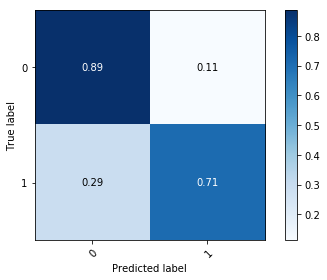

In [11]:
norm_ax, cm = plot_confusion_matrix(y_test, pred, [0,1],
                          normalize=True,
                          title=None,
                          cmap=plt.cm.Blues)

print_performances(cm)